In [7]:
import pandas as pd
import networkx as nx
from modules import ps
import sys
sys.path.append("C:/Users/kubic/Desktop/machine learning/Polarization/")

import functions

import utils
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import umap
import numpy as np

In [5]:
congresses= ['095', '096', '097','098', '099', '100', '101', '102', '103','104', '105', '106', '107','108', '109', '110', '111', '112','113', '114', '115', '116','117','118']

In [6]:
functions.clean_and_prepare_congress_data("116")

FileNotFoundError: [Errno 2] No such file or directory: 'data/USA/H116_members.csv'

In [ ]:
for congress in congresses:
    functions.clean_and_prepare_congress_data(congress)


KeyboardInterrupt: 

In [ ]:
for congress in congresses:
    functions.construct_congress_network(congress)

In [ ]:
pol_scores = {}
for congress in congresses:
    pol_score = functions.calc_pol(congress)  # Run function
    pol_scores[int(congress)] = pol_score  
    print(f"Congress {int(congress)}: Polarization Score = {pol_score}")

Congress 95: Polarization Score = 2.813638588027456
Congress 96: Polarization Score = 4.13022200589418
Congress 97: Polarization Score = 3.5095082658647563
Congress 98: Polarization Score = 8.895562390429738
Congress 99: Polarization Score = 26.8387727352267
Congress 100: Polarization Score = 32.82015944002752
Congress 101: Polarization Score = 16.03677498953517
Congress 102: Polarization Score = 12.089040475233304
Congress 103: Polarization Score = 120.17622990623457
Congress 104: Polarization Score = 199.35872172324508
Congress 105: Polarization Score = 164.9364765070499
Congress 106: Polarization Score = 7.531297995258888
Congress 107: Polarization Score = 8.702001871252023
Congress 108: Polarization Score = 115.20643328742631
Congress 109: Polarization Score = 43.948831612206035
Congress 110: Polarization Score = 129.33156385782698
Congress 111: Polarization Score = 89.47649481463665
Congress 112: Polarization Score = 43.54369601150088
Congress 113: Polarization Score = 83.95152401

This is just average shortest path

In [ ]:
data_path = "data/USA/"  # Adjust if needed

for congress in congresses:
    edge_df = pd.read_csv(f"{data_path}H{congress}_USA_edgelist.csv", delimiter=",")
    
    # Remove any rows with non-numeric values in 'Source' or 'Target' columns
    edge_df = edge_df[pd.to_numeric(edge_df['Source'], errors='coerce').notna()]
    edge_df = edge_df[pd.to_numeric(edge_df['Target'], errors='coerce').notna()]
    
    # Create the graph using the cleaned edge list
    G = nx.from_pandas_edgelist(edge_df, 'Source', 'Target')
    

    
    # Ensure the graph is connected
    if not nx.is_connected(G):
        largest_component = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_component).copy()  # Take the largest component

    # Compute average shortest path length
    avg_path_length = nx.average_shortest_path_length(G)
    print(congress,", ",avg_path_length)

095 ,  1.8639868068439498
096 ,  1.945652739205958
097 ,  1.9509412377557378
098 ,  2.327758188493983
099 ,  2.5574936811558024
100 ,  2.6852039759784634
101 ,  2.2635185976043766
102 ,  2.0933501605770513
103 ,  3.0153370439084726
104 ,  5.2385295831347
105 ,  2.764873222016079
106 ,  1.7831684188827046
107 ,  1.7223171252516625
108 ,  2.870031183150456
109 ,  2.302478118738796
110 ,  3.1220940192472413
111 ,  2.2327146745854987
112 ,  2.1627315803388036
113 ,  2.307558663064781
114 ,  2.70056715648363
115 ,  2.1809948032665183
116 ,  1.7792953929539295
117 ,  2.6196260031787766
118 ,  2.8100741364954205


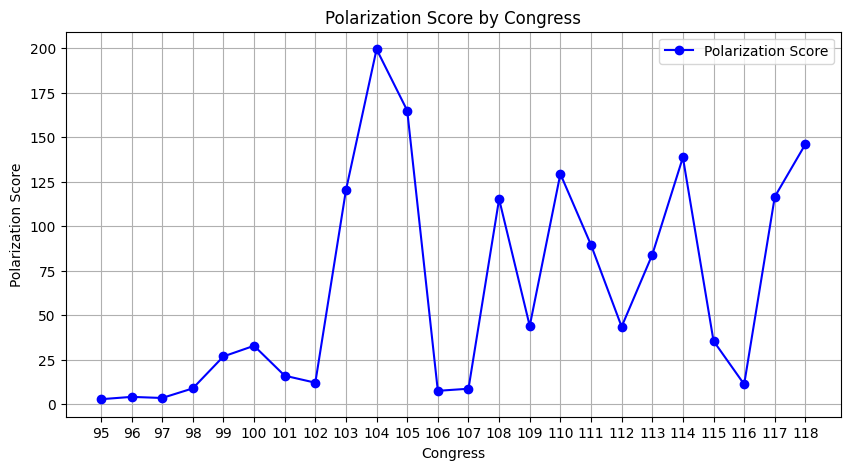

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(pol_scores.keys(), pol_scores.values(), marker='o', linestyle='-', color='b', label="Polarization Score")
plt.xlabel("Congress")
plt.ylabel("Polarization Score")
plt.title("Polarization Score by Congress")
plt.xticks(list(pol_scores.keys()))  # Set x-axis labels to be congress numbers
plt.legend()
plt.grid(True)
plt.show()

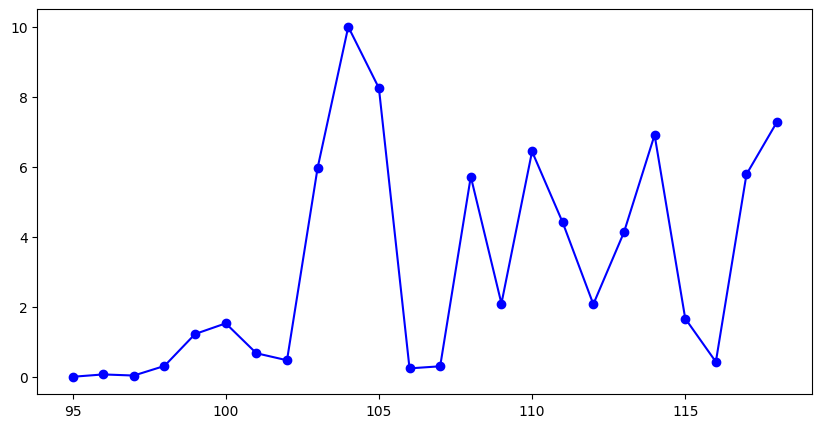

In [ ]:
min_val, max_val = min(pol_scores.values()), max(pol_scores.values())
scaled_scores = {k: 10 * (v - min_val) / (max_val - min_val) for k, v in pol_scores.items()}

# Plot
plt.figure(figsize=(10, 5))
plt.plot(scaled_scores.keys(), scaled_scores.values(), marker='o', linestyle='-', color='b', label="Standardized Polarization")

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
# Compute pairwise distances using cosine similarity
dist_matrix = pairwise_distances(sparse_matrix_us.toarray(), metric='cosine')

# Apply MDS with 2 components
n_components = 2
mds = MDS(n_components=n_components, dissimilarity="precomputed", normalized_stress='auto', random_state=42)
mds_transformed = mds.fit_transform(dist_matrix)

# Extract the first component
raw_values = mds_transformed[:, 0]

# Standardize to range [-1, 1]
min_val, max_val = raw_values.min(), raw_values.max()
standardized_values = 2 * (raw_values - min_val) / (max_val - min_val) - 1

# Store as dictionary with row indices as keys
opinions_x = {index: value for index, value in zip(sparse_df.index, mds_transformed[:, 0])}
opinions_x

{267: 0.02477234846428479,
 633: -0.02633667594888119,
 830: 0.08474330180554274,
 835: 0.2804496694738713,
 948: 0.12806642373132116,
 1077: 0.13503944261745682,
 1087: -0.22204523307484136,
 1265: 0.18506938655507113,
 1282: -0.06039532198226656,
 1610: -0.16662715907506948,
 2009: -0.05228096983489422,
 2476: 0.13559215444119102,
 2513: 0.442644368782808,
 2525: -0.20613112771615955,
 2533: -0.24313932468194438,
 2594: 0.16192686568315467,
 2605: 0.26174470820473816,
 3078: 0.1375438026379007,
 3224: 0.13615460204095803,
 3242: -0.01377073072910687,
 3321: -0.04606777549699499,
 3553: 0.27161098616561713,
 4957: 0.184326159295119,
 5101: 0.09410755492307488,
 5495: -0.20759069100206606,
 5924: 0.06090409030920346,
 6240: 0.14511657865182104,
 6455: -0.14578161958671534,
 6584: 0.10309252946965333,
 6661: 0.13491157508446786,
 6756: 0.33373655712758116,
 6845: 0.04923356478290302,
 6936: 0.296747582536401,
 7081: 0.8241737949731133,
 7333: 0.00447736258980321,
 7343: 0.08184779157745

## Polarization of pca on sparse matrix

In [ ]:
# Function to compute polarization score
def calc_pol(edge_list_path, opinions):
    G = nx.read_edgelist(edge_list_path, delimiter=",")
    G = nx.relabel_nodes(G, lambda x: int(x))  # Convert all nodes to integers
    #o = {int(node): opinions[int(node)] for node in G.nodes if int(node) in opinions}
    import numpy as np

    opinion_values = list(o.values())
    print("Opinion Variance:", np.var(opinion_values))
    

    return ps.ge(opinion_values, {}, G)  

pol_score = calc_pol(edge_list_file, opinions)

print(f"Polarization score: {pol_score}")


NameError: name 'o' is not defined

## Polarization on the nominate score

In [ ]:

G = nx.relabel_nodes(G, lambda x: int(x))  # Convert nodes to integers

# Load the member data
members_df = pd.read_csv("data/USA/H095_members.csv")

# Drop rows where nominate_dim1 is missing (NaN)
members_df = members_df.dropna(subset=["nominate_dim1"])

# Convert ICPSR to integer
members_df["icpsr"] = members_df["icpsr"].astype(int)

# Create opinions_x dictionary {icpsr: nominate_dim1}
opinions_x = dict(zip(members_df["icpsr"], members_df["nominate_dim1"]))

# Ensure only nodes present in the graph are included
opinions = {node: opinions_x[node] for node in G.nodes if node in opinions_x}
# Standardize opinions between -1 and 1 using Min-Max Scaling
min_opinion = min(opinions.values()edge_list_path = "USA_95_edge_list.csv"
G = nx.read_edgelist(edge_list_path, delimiter=","))
max_opinion = max(opinions.values())

opinions = {
    k: 2 * (v - min_opinion) / (max_opinion - min_opinion) - 1
   for k, v in opinions.items()
}

{14404: -0.18287937743190663,
 11023: -0.43060959792477294,
 11007: 0.16601815823605715,
 11037: -0.20103761348897542,
 14219: -0.18158236057068744,
 10788: -0.4824902723735408,
 14276: 0.16212710765239957,
 14410: 0.19325551232166016,
 12014: -0.33722438391699094,
 14467: -0.4539559014267185,
 14026: -0.26977950713359267,
 13048: -0.46433203631647213,
 12038: -0.46433203631647213,
 14016: -0.42801556420233455,
 8032: -0.25680933852140075,
 10446: -0.5901426718547341,
 14451: -0.3696498054474707,
 14429: -0.2970168612191958,
 14227: 0.2529182879377432,
 10587: -0.37094682230869,
 14455: -0.5447470817120622,
 14000: 0.16601815823605715,
 14259: 0.16472114137483795,
 14004: 0.23865110246433208,
 14234: -0.2957198443579766,
 14061: -0.05836575875486383,
 10625: 0.09857328145265876,
 13027: -0.47600518806744485,
 8507: -0.3125810635538262,
 10075: -0.35538261997405973,
 8564: -0.5110246433203631,
 11005: -0.24124513618677035,
 11036: 0.1595330739299612,
 5924: -0.36446173800259407,
 14419:

In [ ]:
# Function to compute polarization score
def calc_pol(edge_list_path, opinions):
    G = nx.read_edgelist(edge_list_path, delimiter=",")
    G = nx.relabel_nodes(G, lambda x: int(x))  # Convert all nodes to integers
    o = {int(node): opinions[int(node)] for node in G.nodes if int(node) in opinions}

    

    return ps.ge(o, {}, G)  

pol_score = calc_pol(edge_list_file, opinions)

print(f"Polarization score: {pol_score}")


NameError: name 'edge_list_file' is not defined

## Opinions distribution

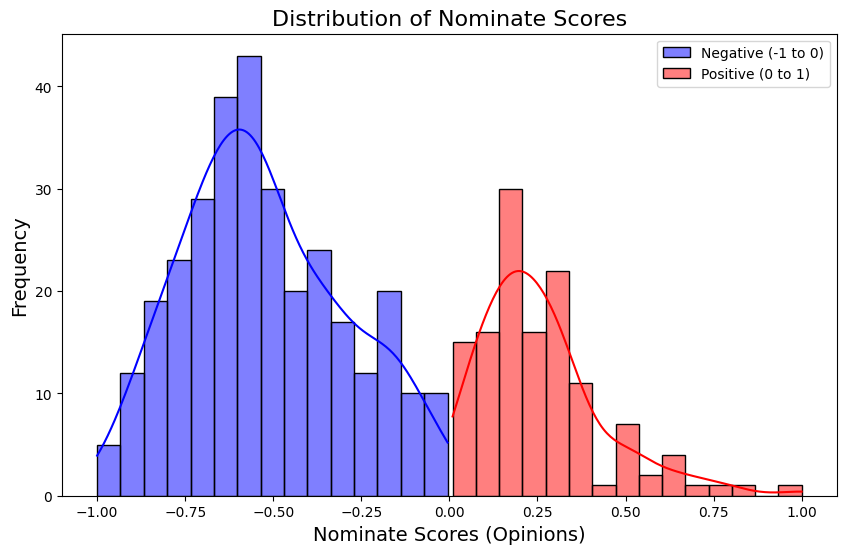

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

opinions_series = pd.Series(opinions)
opinions_neg = opinions_series[opinions_series < 0]  # Negative opinions (-1 to 0)
opinions_pos = opinions_series[opinions_series >= 0]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot negative opinions in blue
sns.histplot(opinions_neg, bins=15, kde=True, color="blue", label="Negative (-1 to 0)")

# Plot positive opinions in red
sns.histplot(opinions_pos, bins=15, kde=True, color="red", label="Positive (0 to 1)")

# Labels and title
plt.xlabel("Nominate Scores (Opinions)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Nominate Scores", fontsize=16)
plt.legend()

# Show the plot
plt.show()

In [ ]:
def calc_pol(edge_list_path,opinions):
    G = nx.read_edgelist(edge_list_path, delimiter=',', comments='s', data=False, nodetype=int)
    o = pd.read_csv(opinions, sep=",").set_index("icpsr")["nominate_dim1"].to_dict()
    return ps.ge(o, {}, G)

members = "data/USA/H095_members.csv"
edge_list_path = "USA_95_edge_list.csv"
print(calc_pol(edge_list_path,members))

2.1693153513691708


In [ ]:
def analyze_polarization_across_congresses(congresses, data_path="data/USA/", output_path="data/USA/results/", 
                               methods=["pca", "mds", "umap"]):
    """
    Calculates and compares polarization across congresses using dimensionality reduction and NOMINATE scores.
    Uses pre-existing network edge lists created by construct_congress_network().
    
    Parameters:
    -----------
    congresses : list
        List of congress numbers (e.g., ['111', '112', '113'])
    data_path : str
        Path to the data directory
    output_path : str
        Path to save output files
    methods : list
        List of dimensionality reduction methods to use: 'pca', 'mds', 'umap'
        
    Returns:
    --------
    dict
        Dictionary containing polarization scores for each congress and method
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import networkx as nx
    import os
    from scipy.sparse import csr_matrix
    from sklearn.decomposition import PCA
    from sklearn.manifold import MDS
    import umap
    from modules import ps
    
    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)
    
    # Dictionary to store polarization scores for each congress
    polarization_results = {}
    
    # Process each congress
    for congress in congresses:
        print(f"\nProcessing {congress}th Congress...")
        congress_polarization = {}
        
        try:
            # Step 1: Load the edge list for the network
            edge_file = f"{data_path}H{congress}_USA_edgelist.csv"
            edge_df = pd.read_csv(edge_file)
            print(f"Loaded edge list for {congress}th Congress with {len(edge_df)} edges")
            
            # Clean up edge data - ensure numeric values
            edge_df = edge_df[pd.to_numeric(edge_df['Source'], errors='coerce').notna()]
            edge_df = edge_df[pd.to_numeric(edge_df['Target'], errors='coerce').notna()]
            
            # Convert to numeric and create graph
            edge_df['Source'] = edge_df['Source'].astype(int)
            edge_df['Target'] = edge_df['Target'].astype(int)
            G = nx.from_pandas_edgelist(edge_df, 'Source', 'Target')
            print(f"Created network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
            
            # Step 2: Load the member data with NOMINATE scores
            members_file = f"{data_path}H{congress}_members.csv"
            members_df = pd.read_csv(members_file)
            members_df = members_df.drop_duplicates(subset=['icpsr'])
            members_df['icpsr'] = members_df['icpsr'].astype(int)
            print(f"Loaded {len(members_df)} members for {congress}th Congress")
            
            # Step 3: Calculate polarization using NOMINATE scores
            if 'nominate_dim1' in members_df.columns:
                # Create a dictionary of NOMINATE scores
                nominate_opinions = dict(zip(members_df['icpsr'], members_df['nominate_dim1']))
                
                # Filter for nodes in the graph and valid values
                nominate_opinions = {k: v for k, v in nominate_opinions.items() 
                                   if k in G.nodes and not pd.isna(v)}
                
                if nominate_opinions:
                    # Normalize to [-1, 1]
                    min_val = min(nominate_opinions.values())
                    max_val = max(nominate_opinions.values())
                    if min_val != max_val:  # Avoid division by zero
                        nominate_opinions_norm = {
                            k: 2 * (v - min_val) / (max_val - min_val) - 1
                            for k, v in nominate_opinions.items()
                        }
                        
                        # Calculate polarization
                        pol_score = ps.ge(nominate_opinions_norm, {}, G)
                        congress_polarization['nominate'] = pol_score
                        print(f"NOMINATE polarization: {pol_score:.4f}")
            
            # Step 4: Load the voting data for dimensionality reduction
            votes_file = f"{data_path}H{congress}_filtered_USA_votes.csv"
            votes_df = pd.read_csv(votes_file)
            print(f"Loaded {len(votes_df)} votes for {congress}th Congress")
            
            # Step 5: Create a sparse matrix of votes
            reps = votes_df['icpsr'].unique()
            roll_calls = votes_df['rollnumber'].unique()
            
            rep_to_idx = {rep: i for i, rep in enumerate(reps)}
            roll_to_idx = {roll: j for j, roll in enumerate(roll_calls)}
            
            row_indices = []
            col_indices = []
            values = []
            
            for _, row in votes_df.iterrows():
                rep_idx = rep_to_idx[row['icpsr']]
                roll_idx = roll_to_idx[row['rollnumber']]
                row_indices.append(rep_idx)
                col_indices.append(roll_idx)
                values.append(row['cast_code'])
            
            # Create the sparse matrix
            sparse_matrix = csr_matrix((values, (row_indices, col_indices)), 
                                      shape=(len(reps), len(roll_calls)))
            
            # Create a DataFrame linking sparse matrix rows to representative IDs
            sparse_df = pd.DataFrame({'icpsr': reps})
            
            # Step 6: Perform dimensionality reduction for each method
            if 'pca' in methods:
                print("Performing PCA...")
                pca = PCA(n_components=2)
                pca_result = pca.fit_transform(sparse_matrix.toarray())
                sparse_df['pca_1'] = pca_result[:, 0]
                sparse_df['pca_2'] = pca_result[:, 1]
                
                # Calculate polarization using PCA
                sparse_df['icpsr'] = sparse_df['icpsr'].astype(int)
                pca_opinions = dict(zip(sparse_df['icpsr'], sparse_df['pca_1']))
                
                # Filter for nodes in the graph and valid values
                pca_opinions = {k: v for k, v in pca_opinions.items() 
                              if k in G.nodes and not pd.isna(v)}
                
                if pca_opinions:
                    # Normalize to [-1, 1]
                    min_val = min(pca_opinions.values())
                    max_val = max(pca_opinions.values())
                    if min_val != max_val:  # Avoid division by zero
                        pca_opinions_norm = {
                            k: 2 * (v - min_val) / (max_val - min_val) - 1
                            for k, v in pca_opinions.items()
                        }
                        
                        # Calculate polarization
                        pol_score = ps.ge(pca_opinions_norm, {}, G)
                        congress_polarization['pca'] = pol_score
                        print(f"PCA polarization: {pol_score:.4f}")
            
            if 'mds' in methods:
                print("Performing MDS...")
                from sklearn.metrics.pairwise import cosine_distances
                dist_matrix = cosine_distances(sparse_matrix)
                mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, n_jobs=-1)
                mds_result = mds.fit_transform(dist_matrix)
                sparse_df['mds_1'] = mds_result[:, 0]
                sparse_df['mds_2'] = mds_result[:, 1]
                
                # Calculate polarization using MDS
                mds_opinions = dict(zip(sparse_df['icpsr'], sparse_df['mds_1']))
                
                # Filter for nodes in the graph and valid values
                mds_opinions = {k: v for k, v in mds_opinions.items() 
                              if k in G.nodes and not pd.isna(v)}
                
                if mds_opinions:
                    # Normalize to [-1, 1]
                    min_val = min(mds_opinions.values())
                    max_val = max(mds_opinions.values())
                    if min_val != max_val:  # Avoid division by zero
                        mds_opinions_norm = {
                            k: 2 * (v - min_val) / (max_val - min_val) - 1
                            for k, v in mds_opinions.items()
                        }
                        
                        # Calculate polarization
                        pol_score = ps.ge(mds_opinions_norm, {}, G)
                        congress_polarization['mds'] = pol_score
                        print(f"MDS polarization: {pol_score:.4f}")
            
            if 'umap' in methods:
                print("Performing UMAP...")
                reducer = umap.UMAP(n_components=2, random_state=42)
                umap_result = reducer.fit_transform(sparse_matrix.toarray())
                sparse_df['umap_1'] = umap_result[:, 0]
                sparse_df['umap_2'] = umap_result[:, 1]
                
                # Calculate polarization using UMAP
                umap_opinions = dict(zip(sparse_df['icpsr'], sparse_df['umap_1']))
                
                # Filter for nodes in the graph and valid values
                umap_opinions = {k: v for k, v in umap_opinions.items() 
                              if k in G.nodes and not pd.isna(v)}
                
                if umap_opinions:
                    # Normalize to [-1, 1]
                    min_val = min(umap_opinions.values())
                    max_val = max(umap_opinions.values())
                    if min_val != max_val:  # Avoid division by zero
                        umap_opinions_norm = {
                            k: 2 * (v - min_val) / (max_val - min_val) - 1
                            for k, v in umap_opinions.items()
                        }
                        
                        # Calculate polarization
                        pol_score = ps.ge(umap_opinions_norm, {}, G)
                        congress_polarization['umap'] = pol_score
                        print(f"UMAP polarization: {pol_score:.4f}")
            
            # Save results for this congress
            polarization_results[congress] = congress_polarization
            
            # Save the dimensionality reduction results for future use
            sparse_df.to_csv(f"{output_path}H{congress}_dimensionality_reduction.csv", index=False)
            
        except Exception as e:
            print(f"Error processing {congress}th Congress: {e}")
    
    # Plot the polarization scores if we have results
    if polarization_results:
        try:
            # Convert to DataFrame for easier plotting
            pol_df = pd.DataFrame.from_dict(polarization_results, orient='index')
            
            # Sort by congress number
            pol_df = pol_df.reset_index().rename(columns={'index': 'congress'})
            pol_df['congress_num'] = pol_df['congress'].astype(int)
            pol_df = pol_df.sort_values('congress_num').set_index('congress')
            pol_df = pol_df.drop('congress_num', axis=1)
            
            # Create the plot
            plt.figure(figsize=(12, 8))
            
            # Plot NOMINATE first
            if 'nominate' in pol_df.columns:
                plt.plot(pol_df.index, pol_df['nominate'], 'ko-', linewidth=2, markersize=8, label='NOMINATE')
            
            # Then each method with different styles
            styles = {
                'pca': ('bs--', 'blue', 'PCA'),
                'mds': ('rd--', 'red', 'MDS'),
                'umap': ('g^--', 'green', 'UMAP')
            }
            
            for method in methods:
                if method in pol_df.columns:
                    style, color, label = styles.get(method, ('o--', 'gray', method.upper()))
                    plt.plot(pol_df.index, pol_df[method], style, 
                            linewidth=1.5, markersize=8, label=label)
            
            plt.title('Congressional Polarization Over Time', fontsize=16)
            plt.xlabel('Congress', fontsize=14)
            plt.ylabel('Polarization Score', fontsize=14)
            plt.ylim(0, 1)
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.legend(fontsize=12)
            plt.xticks(pol_df.index)
            plt.tight_layout()
            
            # Save the plot
            plt.savefig(f"{output_path}polarization_over_time.png", dpi=300)
            print(f"Saved polarization plot to {output_path}polarization_over_time.png")
            
            # Also save the plot with a timestamp for easy reference
            import datetime
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            plt.savefig(f"{output_path}polarization_over_time_{timestamp}.png", dpi=300)
            
            # Save the data
            pol_df.to_csv(f"{output_path}polarization_scores.csv")
            print(f"Saved polarization data to {output_path}polarization_scores.csv")
            
            # Also display the plot
            plt.show()
            
        except Exception as e:
            print(f"Error creating polarization plot: {e}")
    
    return polarization_results

# Example usage:
# congresses = ['111', '112', '113', '114', '115', '116', '117']
# results = analyze_polarization_across_congresses(congresses, data_path="data/USA/", output_path="data/USA/results/")


Processing 095th Congress...
Loaded edge list for 095th Congress with 69166 edges
Created network with 441 nodes and 34577 edges
Loaded 442 members for 095th Congress
NOMINATE polarization: 2.8136
Loaded 601981 votes for 095th Congress
Performing PCA...
PCA polarization: 3.5448
Performing MDS...
MDS polarization: 0.8108
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 3.6497

Processing 096th Congress...
Loaded edge list for 096th Congress with 64011 edges
Created network with 439 nodes and 31983 edges
Loaded 443 members for 096th Congress
NOMINATE polarization: 4.1302
Loaded 495357 votes for 096th Congress
Performing PCA...
PCA polarization: 4.4554
Performing MDS...
MDS polarization: 0.8248
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 5.0655

Processing 097th Congress...
Loaded edge list for 097th Congress with 62528 edges
Created network with 443 nodes and 31261 edges
Loaded 445 members for 097th Congress
NOMINATE polarization: 3.5095
Loaded 317932 votes for 097th Congress
Performing PCA...
PCA polarization: 1.9248
Performing MDS...
MDS polarization: 0.7241
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 4.5142

Processing 098th Congress...
Loaded edge list for 098th Congress with 65614 edges
Created network with 439 nodes and 32807 edges
Loaded 441 members for 098th Congress
NOMINATE polarization: 8.8956
Loaded 362405 votes for 098th Congress
Performing PCA...
PCA polarization: 12.2565
Performing MDS...
MDS polarization: 1.6212
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 14.3542

Processing 099th Congress...
Loaded edge list for 099th Congress with 61203 edges
Created network with 439 nodes and 30601 edges
Loaded 440 members for 099th Congress
NOMINATE polarization: 26.8388
Loaded 360462 votes for 099th Congress
Performing PCA...
PCA polarization: 31.9852
Performing MDS...
MDS polarization: 4.0602
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 42.6523

Processing 100th Congress...
Loaded edge list for 100th Congress with 64627 edges
Created network with 440 nodes and 32313 edges
Loaded 442 members for 100th Congress
NOMINATE polarization: 32.8202
Loaded 378233 votes for 100th Congress
Performing PCA...
PCA polarization: 36.8818
Performing MDS...
MDS polarization: 6.5737
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 51.3240

Processing 101th Congress...
Loaded edge list for 101th Congress with 64401 edges
Created network with 444 nodes and 32200 edges
Loaded 446 members for 101th Congress
NOMINATE polarization: 16.0368
Loaded 361974 votes for 101th Congress
Performing PCA...
PCA polarization: 14.8803
Performing MDS...
MDS polarization: 4.0818
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 25.2393

Processing 102th Congress...
Loaded edge list for 102th Congress with 61760 edges
Created network with 442 nodes and 30879 edges
Loaded 442 members for 102th Congress
NOMINATE polarization: 12.0890
Loaded 367020 votes for 102th Congress
Performing PCA...
PCA polarization: 13.3626
Performing MDS...
MDS polarization: 3.2091
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 24.3190

Processing 103th Congress...
Loaded edge list for 103th Congress with 59933 edges
Created network with 441 nodes and 29967 edges
Loaded 448 members for 103th Congress
NOMINATE polarization: 120.1762
Loaded 455068 votes for 103th Congress
Performing PCA...
PCA polarization: 135.6631
Performing MDS...
MDS polarization: 11.1137
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 206.9495

Processing 104th Congress...
Loaded edge list for 104th Congress with 65536 edges
Created network with 435 nodes and 32768 edges
Loaded 446 members for 104th Congress
NOMINATE polarization: 199.3587
Loaded 551552 votes for 104th Congress
Performing PCA...
PCA polarization: 309.3065
Performing MDS...
MDS polarization: 42.0598
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 333.8105

Processing 105th Congress...
Loaded edge list for 105th Congress with 58251 edges
Created network with 441 nodes and 29126 edges
Loaded 445 members for 105th Congress
NOMINATE polarization: 164.9365
Loaded 310385 votes for 105th Congress
Performing PCA...
PCA polarization: 215.2304
Performing MDS...
MDS polarization: 17.6723
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 259.8981

Processing 106th Congress...
Loaded edge list for 106th Congress with 94251 edges
Created network with 441 nodes and 47125 edges
Loaded 441 members for 106th Congress
NOMINATE polarization: 7.5313
Loaded 499590 votes for 106th Congress
Performing PCA...
PCA polarization: 10.9063
Performing MDS...
MDS polarization: 0.5417
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 12.7832

Processing 107th Congress...
Loaded edge list for 107th Congress with 96719 edges
Created network with 444 nodes and 48358 edges
Loaded 445 members for 107th Congress
NOMINATE polarization: 8.7020
Loaded 409733 votes for 107th Congress
Performing PCA...
PCA polarization: 12.1655
Performing MDS...
MDS polarization: 0.1805
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 14.8201

Processing 108th Congress...
Loaded edge list for 108th Congress with 59612 edges
Created network with 434 nodes and 29807 edges
Loaded 441 members for 108th Congress
NOMINATE polarization: 115.2064
Loaded 502499 votes for 108th Congress
Performing PCA...
PCA polarization: 174.5342
Performing MDS...
MDS polarization: 22.0526
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 186.3217

Processing 109th Congress...
Loaded edge list for 109th Congress with 58461 edges
Created network with 436 nodes and 29229 edges
Loaded 441 members for 109th Congress
NOMINATE polarization: 43.9488
Loaded 502360 votes for 109th Congress
Performing PCA...
PCA polarization: 65.4003
Performing MDS...
MDS polarization: 9.1843
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 71.5660

Processing 110th Congress...
Loaded edge list for 110th Congress with 62950 edges
Created network with 446 nodes and 31474 edges
Loaded 454 members for 110th Congress
NOMINATE polarization: 129.3316
Loaded 769847 votes for 110th Congress
Performing PCA...
PCA polarization: 141.0840
Performing MDS...
MDS polarization: 14.2563
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 198.2365

Processing 111th Congress...
Loaded edge list for 111th Congress with 85305 edges
Created network with 450 nodes and 42653 edges
Loaded 455 members for 111th Congress
NOMINATE polarization: 89.4765
Loaded 681469 votes for 111th Congress
Performing PCA...
PCA polarization: 80.3356
Performing MDS...
MDS polarization: 16.3379
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 146.5825

Processing 112th Congress...
Loaded edge list for 112th Congress with 70487 edges
Created network with 444 nodes and 35240 edges
Loaded 446 members for 112th Congress
NOMINATE polarization: 43.5437
Loaded 666195 votes for 112th Congress
Performing PCA...
PCA polarization: 65.4338
Performing MDS...
MDS polarization: 12.0112
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 42.5719

Processing 113th Congress...
Loaded edge list for 113th Congress with 66738 edges
Created network with 435 nodes and 33368 edges
Loaded 445 members for 113th Congress
NOMINATE polarization: 83.9515
Loaded 498696 votes for 113th Congress
Performing PCA...
PCA polarization: 129.0847
Performing MDS...
MDS polarization: 17.4235
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 127.7273

Processing 114th Congress...
Loaded edge list for 114th Congress with 62131 edges
Created network with 432 nodes and 31065 edges
Loaded 442 members for 114th Congress
NOMINATE polarization: 138.6160
Loaded 551463 votes for 114th Congress
Performing PCA...
PCA polarization: 205.8307
Performing MDS...
MDS polarization: 20.2482
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 205.4747

Processing 115th Congress...
Loaded edge list for 115th Congress with 65967 edges
Created network with 450 nodes and 32979 edges
Loaded 451 members for 115th Congress
NOMINATE polarization: 35.5363
Loaded 496935 votes for 115th Congress
Performing PCA...
PCA polarization: 39.4395
Performing MDS...
MDS polarization: 4.0067
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 49.4969

Processing 116th Congress...
Loaded edge list for 116th Congress with 100685 edges
Created network with 451 nodes and 50341 edges
Loaded 452 members for 116th Congress
NOMINATE polarization: 11.2121
Loaded 396582 votes for 116th Congress
Performing PCA...
PCA polarization: 12.4108
Performing MDS...
MDS polarization: 2.0512
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 16.4970

Processing 117th Congress...
Loaded edge list for 117th Congress with 67394 edges
Created network with 452 nodes and 33698 edges
Loaded 457 members for 117th Congress
NOMINATE polarization: 116.5152
Loaded 420524 votes for 117th Congress
Performing PCA...
PCA polarization: 98.5145
Performing MDS...
MDS polarization: 16.7387
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 185.0302

Processing 118th Congress...
Loaded edge list for 118th Congress with 62226 edges
Created network with 447 nodes and 31114 edges
Loaded 451 members for 118th Congress
NOMINATE polarization: 146.1378
Loaded 516591 votes for 118th Congress
Performing PCA...
PCA polarization: 150.4090
Performing MDS...
MDS polarization: 2.6969
Performing UMAP...


/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP polarization: 227.8195
Saved polarization plot to data/USA/results/polarization_over_time.png
Saved polarization data to data/USA/results/polarization_scores.csv


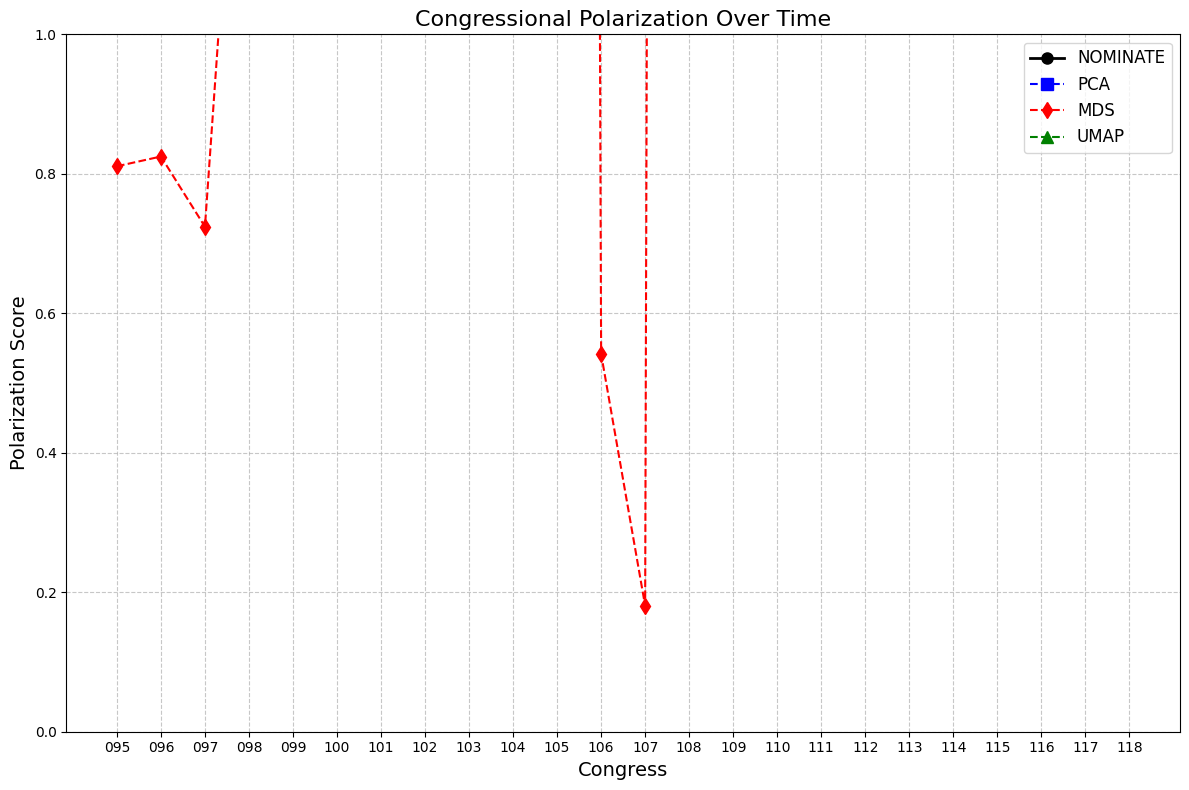

In [ ]:
results = analyze_polarization_across_congresses(congresses, data_path="data/USA/", output_path="data/USA/results/")

In [ ]:
results

{'095': {'nominate': np.float64(2.8136385880274557),
  'pca': np.float64(3.5448425565058863),
  'mds': np.float64(0.8108155938976677),
  'umap': np.float64(3.649692176508068)},
 '096': {'nominate': np.float64(4.130222005894182),
  'pca': np.float64(4.455390324952329),
  'mds': np.float64(0.8248088116924507),
  'umap': np.float64(5.06554283998863)},
 '097': {'nominate': np.float64(3.509508265864756),
  'pca': np.float64(1.9247674657288554),
  'mds': np.float64(0.7241379958204408),
  'umap': np.float64(4.5141801684437395)},
 '098': {'nominate': np.float64(8.895562390429774),
  'pca': np.float64(12.25650571532524),
  'mds': np.float64(1.6212353787871026),
  'umap': np.float64(14.354239894832928)},
 '099': {'nominate': np.float64(26.83877273522547),
  'pca': np.float64(31.985162200538202),
  'mds': np.float64(4.060199070952383),
  'umap': np.float64(42.65225989891636)},
 '100': {'nominate': np.float64(32.82015944002657),
  'pca': np.float64(36.8817524570905),
  'mds': np.float64(6.57372263

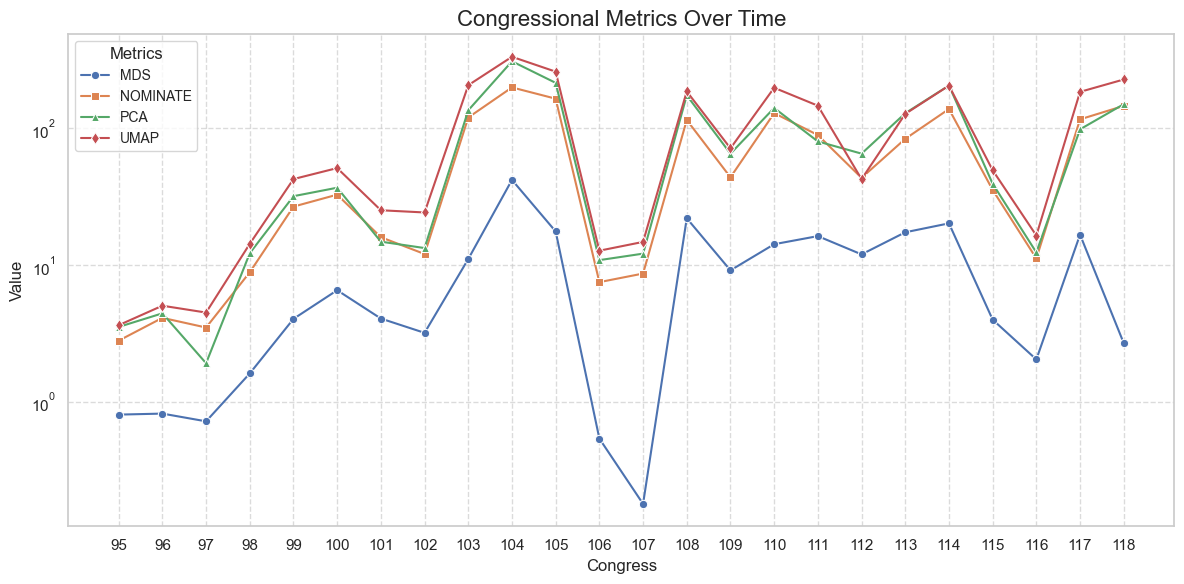

<Figure size 640x480 with 0 Axes>

In [36]:

results = pd.read_csv("data/USA/results/polarization_scores.csv")
records = []
for congress, metrics in results.items():
    record = {'congress': congress}
    record.update(metrics)
    records.append(record)

# Create DataFrame and handle missing values
df = pd.DataFrame(records)
df = df.sort_values('congress')
df_transposed = df.set_index(df.columns[0]).T
#df_transposed.pop('congress')
df_transposed
# Assuming df_transposed is your DataFrame with columns: congress, mds, nominate, pca, umap
# and congress is the column to be used as x-axis

# Set the style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Create the line plot
sns.lineplot(data=df_transposed, x='congress', y='mds', marker='o', label='MDS')
sns.lineplot(data=df_transposed, x='congress', y='nominate', marker='s', label='NOMINATE')
sns.lineplot(data=df_transposed, x='congress', y='pca', marker='^', label='PCA')
sns.lineplot(data=df_transposed, x='congress', y='umap', marker='d', label='UMAP')

plt.yscale('log')


# Customize the plot
plt.title('Congressional Metrics Over Time', fontsize=16)
plt.xlabel('Congress', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(title='Metrics', fontsize=10)

# Make sure x-axis shows integer values for Congress
plt.xticks(df_transposed['congress'])

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Tight layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()

# Alternatively, save the figure
plt.savefig('congress_metrics_logsclae.png', dpi=300, bbox_inches='tight')